In [3]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import scipy.stats as scs

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline



import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
data = pd.read_csv('task1.csv', index_col='data')

In [5]:
data.head()

,value
data,
01.01.2019,14.77
02.01.2019,14.83
03.01.2019,16.20
05.01.2019,15.50
06.01.2019,15.16


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 01.01.2019 to 03.06.2019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   140 non-null    float64
dtypes: float64(1)
memory usage: 1.6+ KB


In [8]:
# Построим временной ряд

fig = px.line(data, title="Value-time dependancy")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [9]:
px.line(data.rolling(window=30).mean()[30:], title='Rolling mean trend, window = month')

In [10]:
# Построим изменения скользящего среднего

diff_data = data.diff(periods=1).dropna()
px.line(diff_data.rolling(window=30).mean()[30:], title='Rolling mean trend, window = month')

#### После диффиренцирования на графике скользящего среднего заметно отсутствие тренда

In [26]:
#Запишем функцию для высичления Критерия Дики-Фуллера, КПСС и построения графиков автокорреляции и частичной автокорреляции

def stationarity(data, lags=25):
    warnings.filterwarnings('ignore')
    print('Dickey-Fuller p-val = {}'.format(sm.tsa.stattools.adfuller(diff_data)[1]))
    print('KPSS p-val = {}'.format(sm.tsa.stattools.kpss(diff_data)[1]))
    plot_acf(data, lags=lags)
    plot_pacf(data, lags=lags)
    plt.show()

In [12]:
#Делаем сезонное дифференциирование

diff_data = diff_data.diff(periods=35).dropna()

Dickey-Fuller p-val = 8.317201697951678e-07
KPSS p-val = 0.1


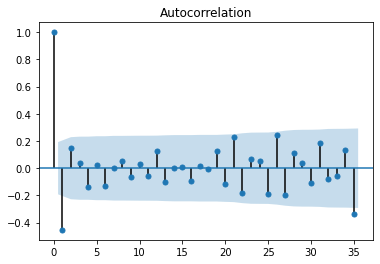

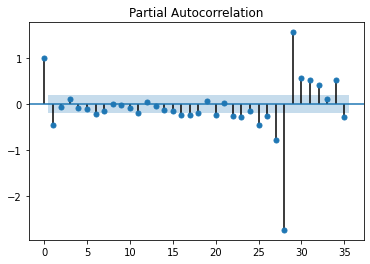

In [13]:
stationarity(diff_data, lags=35)

In [27]:
# Устанавливаем параметры SARIMA
d = 1 
D = 1
qs = range(0, 2)
Qs = range(0, 2)
ps = range(20, 25)
Ps = range(0, 2)

In [18]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [19]:
#ищем оптимальные параметры для SARIMA-модели, используя информационный критерий

%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=SARIMAX(data.value, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 35)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [2:38:57<00:00, 238.43s/it]

       parameters         aic
7   (20, 1, 1, 1)  182.421735
39  (24, 1, 1, 1)  183.138455
23  (22, 1, 1, 1)  183.446260
19  (22, 0, 1, 1)  183.726446
15  (21, 1, 1, 1)  184.151199
Wall time: 2h 38min 57s


In [20]:
# обучаем модель с лучшими выбранными параметрами

%%time
best_model = SARIMAX(data.value, order=(best_param[0], d, best_param[1]), 
                                        seasonal_order=(best_param[2], D, best_param[3], 24)).fit()
print(best_model.summary())

c:\users\miair\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\users\miair\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

c:\users\miair\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  140
Model:             SARIMAX(20, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -216.711
Date:                             Sun, 09 Aug 2020   AIC                            481.422
Time:                                     19:14:30   BIC                            547.300
Sample:                                          0   HQIC                           508.161
                                             - 140                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6344      0.182      3.491      0.000       0.278       0.991
ar.L2          0.0561      

In [21]:
# в данной функции реалитзуем построение графиков автокрорреляции, частичной автокорреляции и остатков 

warnings.filterwarnings('ignore')

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.000000


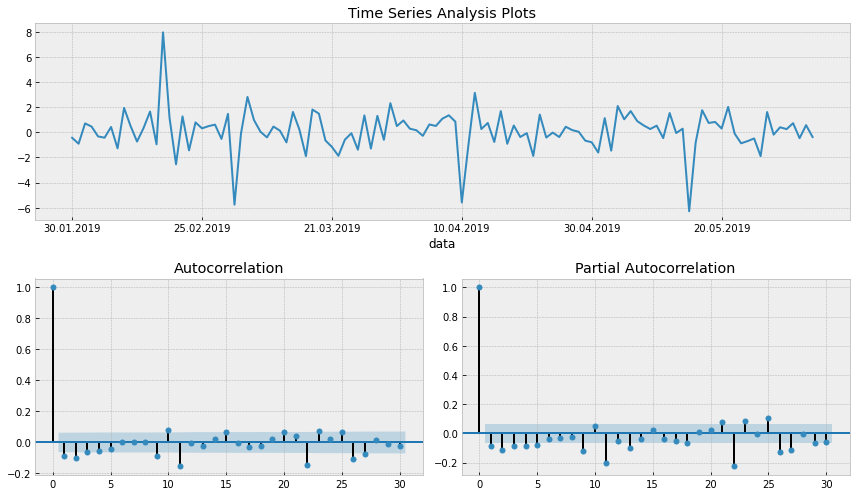

In [22]:
tsplot(best_model.resid[25:], lags=30)

In [23]:
data2 = data.copy()
data2["sarima_model"] = best_model.fittedvalues

In [24]:
fig = px.line(data2, title='RMSE = {}'.format(mean_squared_error(data.value, data2.sarima_model, squared=False)))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

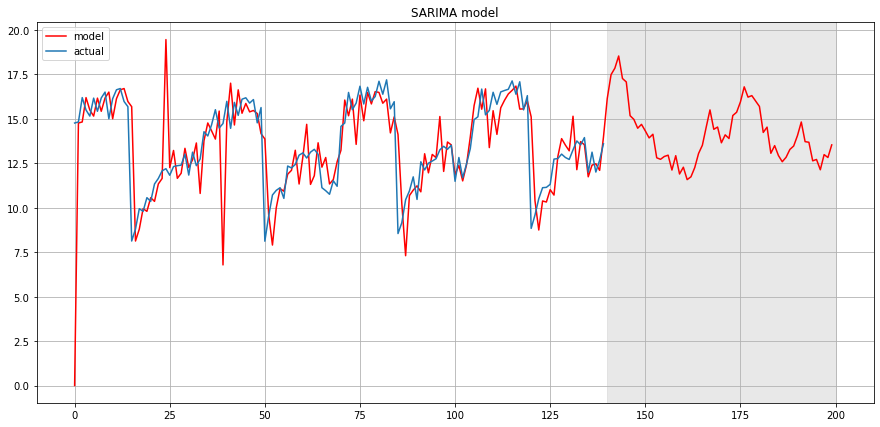

In [25]:
# Строим предсказания

predictions = best_model.predict(start=data2.shape[0], end=data2.shape[0] + 59)
predictions = data2.sarima_model.append(predictions).values
actual = data2.value.values
plt.figure(figsize=(15, 7))
plt.plot(predictions, color='r', label="model")
plt.title("SARIMA model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(predictions), alpha=0.5, color='lightgrey')
plt.grid(True)

#### Несмотря на неплохое значение RMSE, стационарности остатков по критерию Дики-Фулера и отсутствию очевидно значимых автокорреляций, предсказания, полученные при помощи модели SARIMA  получились хуже, чем полученные при помощи модели Хольта-Винтерса